# Tests for a pipeline using prototypical kernels + Riemann classif

In [50]:
import mne
from mne.filter import construct_iir_filter

import pyxdf
import numpy as np


from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from pyriemann.utils.mean import mean_riemann
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import _add_alpha

import matplotlib.pyplot as plt   

from autoreject import AutoReject

from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance 

from scipy.linalg import sqrtm, inv 

In [51]:
kernels = np.load("C:\\Users\\ludov\\Documents\\repos\\MIonline\\classification\\pipeline\\new_kernels_session_3.npy", allow_pickle=True)
k_shape = kernels.shape
if len(k_shape) == 3:
        kernels = kernels.reshape(k_shape[0]*k_shape[1], -1)
kernels = kernels[:4]
kernels = [1]
# Load data
fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\1605\\true_move.xdf'
streams, header = pyxdf.load_xdf(fname)
for idx, stream in enumerate(streams):
        if stream['info']['type'][0] == 'EEG':
                eeg_stream = idx
        elif stream['info']['name'][0] == 'MotorImageryMarkers':
                marker_stream = idx

data = streams[eeg_stream]["time_series"].T
#transformation from uV to V
data[:] *= 1e-6

# Retrieve the number of channels
ch_count = int(streams[eeg_stream]['info']['channel_count'][0])
# Retrieve the channel names
ch_names = [streams[eeg_stream]['info']['desc'][0]['channels'][0]['channel'][ch_nb]['label'][0] for ch_nb in range(ch_count)]

# electrode selection
# list_elect = ["FC1", "Fz", "FC2", "C3", "Cz", "C4", "CP1", "Pz", "CP2"]= [8,4,9,12,13,14,18,24,19]
idx_ch = [8,4,9,12,13,14,18,24,19]
ch_names = np.array(ch_names)[idx_ch]
ch_count = len(ch_names)
data = data[idx_ch,:]

# Average re-referencing
ref_data = data.mean(0, keepdims=True)
data -= ref_data
data = data.astype(np.float64)

assert data.shape[0] == ch_count  # 8 channels
sfreq = float(streams[eeg_stream]["info"]["nominal_srate"][0])
info = mne.create_info(list(ch_names), sfreq, ['eeg'] * ch_count )
raw = mne.io.RawArray(data, info)

# Load markers
# get difference between EEG onset and onset of Triggers
eeg_onset = streams[eeg_stream]["time_stamps"][0] 
trigger_timestamps = streams[marker_stream]["time_stamps"][:60] - eeg_onset

# get names of triggers (it's a nested list in the xdf file)    
# turn nested list into "normal" one dimensional list
trigger_descriptions = np.array(streams[marker_stream]["time_series"][:60]).astype(int).ravel()

# save trigger descriptions & their onsets as annotations for our Raw object
triggers_annot = mne.Annotations(onset = trigger_timestamps, duration = 4., description = trigger_descriptions)
# Add trigger annotations to the Raw object that's already containing the EEG data
raw = raw.set_annotations(triggers_annot)
standard_1020 = mne.channels.make_standard_montage("standard_1020")
raw = raw.set_montage(standard_1020)

# SOS filtering
low = 10
high = 40
iir_params = dict(order=2, ftype='butter', output='sos')  
iir_params = construct_iir_filter(iir_params, f_pass= [low,high], sfreq=sfreq, btype='bandpass', return_copy=True)
print((2 * len(iir_params['sos']), iir_params['padlen']))
raw = raw.filter(low, high, method='iir', iir_params=iir_params)

Creating RawArray with float64 data, n_channels=9, n_times=324150
    Range : 0 ... 324149 =      0.000 ...  1296.596 secs
Ready.

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 10.00, 40.00 Hz: -6.02, -6.02 dB

(4, 52)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 40 Hz



Epochs extraction

In [52]:
# Extract epochs
events, event_id = mne.events_from_annotations(raw, verbose="warning") 

epochs = mne.Epochs(raw, events, tmin=0.5, tmax=3.5, 
        event_id=event_id, preload = True, baseline=None, verbose = "warning") 
ar = AutoReject(n_interpolate=np.array([0]))
epochs = ar.fit_transform(epochs)  
epochs_MI_stage2 = epochs.get_data(copy=False).astype(np.float64)[:,:,:-1] 
labels_MI_stage2 = epochs.events[:, -1] - 1  # 0, 1 instead of 1, 2

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=0


  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

Dropped 3 epochs: 3, 4, 19


In [53]:
# # Retrieve beta reboud related epochs
# Remove epochs every 5 events because they include keyboard press
# indices_to_keep = np.delete(np.arange(events.shape[0]), np.arange(4, events.shape[0], 5))
# # Use the indices to index into the events array
# events = events[indices_to_keep]
epochs = mne.Epochs(raw, events, tmin=5.5, tmax=8.5, 
        event_id=event_id, preload = True, baseline=None, verbose = "warning") 
ar = AutoReject(n_interpolate=np.array([0]))
epochs = ar.fit_transform(epochs) 
# Get rebound epochs and labels
epochs_rebound = epochs.get_data(copy=False).astype(np.float64)[:,:,:-1]
labels_rebound = np.zeros(len(epochs_rebound))  # Rebound label is 0

# Create dataset to distinguish between MI and rebound
# Downsample MI epochs to the same number of rebound epochs
# idx = np.arange(0, len(epochs_MI_stage2), 1)
# idx = np.random.choice(idx, len(epochs_rebound), replace=False)
epochs_MI_stage1 = np.copy(epochs_MI_stage2)#[idx]
labels_MI_stage1 = np.zeros(len(epochs_MI_stage1)) + 1  # MI label is 1

# Combine MI and rebound epochs and labels
combined_epochs = np.concatenate((epochs_MI_stage1, epochs_rebound), axis=0)
combined_labels = np.concatenate((labels_MI_stage1, labels_rebound), axis=0).astype(int)

cov_matrices = Covariances(estimator='oas').fit_transform(combined_epochs)
refEA = mean_covariance(cov_matrices, metric='euclid')
R_inv = sqrtm(inv(refEA))
epochs_MI_stage2 = np.einsum('ij,tjk->tik', R_inv, epochs_MI_stage2)

combined_epochs = np.einsum('ij,tjk->tik', R_inv, combined_epochs)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=0


  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

Dropped 3 epochs: 8, 38, 48


# Spatial covariance estimation
Done by block to have one per kernel and then put on a diagonal

In [54]:
from pyriemann.estimation import BlockCovariances
cov_ext_trials = BlockCovariances(
    estimator='oas', block_size=len(ch_names)
).transform(combined_epochs)

### Show examplefor each class

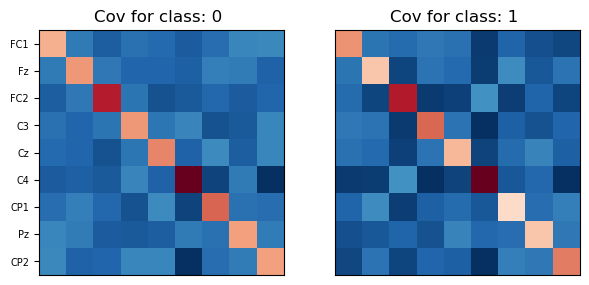

In [55]:
plt.figure(figsize=(7, 7))
event_id = list(set(combined_labels))
for i, l in enumerate(event_id):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(cov_ext_trials[combined_labels == event_id[l]][10],
               cmap=plt.get_cmap('RdBu_r'))
    plt.title(f'Cov for class: {l} ')
    plt.xticks([])
    if i == 0 or i == 2:
        plt.yticks(np.arange(len(ch_names)), ch_names)
        ax.tick_params(axis='both', which='major', labelsize=7)
    else:
        plt.yticks([])

## Classify with MDM

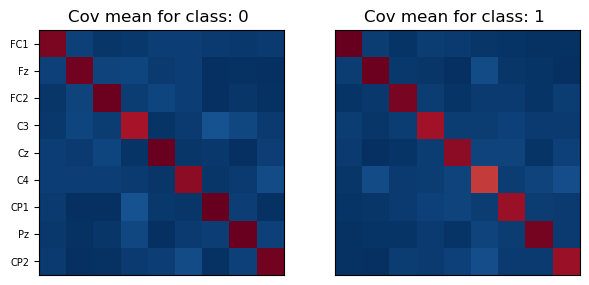

In [56]:

cov_centers = np.empty((len(event_id), len(ch_names)*len(kernels), len(ch_names)*len(kernels)))
for i, l in enumerate(event_id):
    cov_centers[i] = mean_riemann(cov_ext_trials[combined_labels == event_id[l]])

plt.figure(figsize=(7, 7))
for i, l in enumerate(event_id):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(cov_centers[i], cmap=plt.get_cmap('RdBu_r'))
    plt.title(f'Cov mean for class: {l} ')
    plt.xticks([])
    if i == 0 or i == 2:
        plt.yticks(np.arange(len(ch_names)), ch_names)
        ax.tick_params(axis='both', which='major', labelsize=7)
    else:
        plt.yticks([])

In [57]:
print("Number of trials: {}".format(len(cov_ext_trials)))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
mdm = MDM(metric=dict(mean='euclid', distance='euclid'))
scores = cross_val_score(mdm, cov_ext_trials, combined_labels, cv=cv, n_jobs=1)
print("MDM accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))

Number of trials: 114
MDM accuracy: 55.27% +/- 10.31


In [58]:
mdm.fit(cov_ext_trials, combined_labels)

MDM(metric={'distance': 'euclid', 'mean': 'euclid'})

## Projection in tangent space to viz

In [59]:
pga = make_pipeline(
    TangentSpace(metric="euclid", tsupdate=False),
    PCA(n_components=2)
)

ts_train = pga.fit_transform(cov_ext_trials)
ts_means = pga.transform(np.array(mdm.covmeans_))

In [60]:
clabel = ['MI', 'rebound']
cmap = plt.cm.winter

def plot_pga(ax, data, labels, centers):
    sc = ax.scatter(data[:, 0], data[:, 1], c=labels, marker='P', cmap=cmap)
    ax.scatter(
        centers[:, 0], centers[:, 1], c=np.array([0,1]), marker='o', s=100, cmap=cmap
        )
    ax.set(xlabel='PGA, 1st axis', ylabel='PGA, 2nd axis')
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/(len(clabel)-1)), markersize=10) for i in range(len(clabel))]
    ax.legend(handles, clabel, loc='upper right')
    return sc

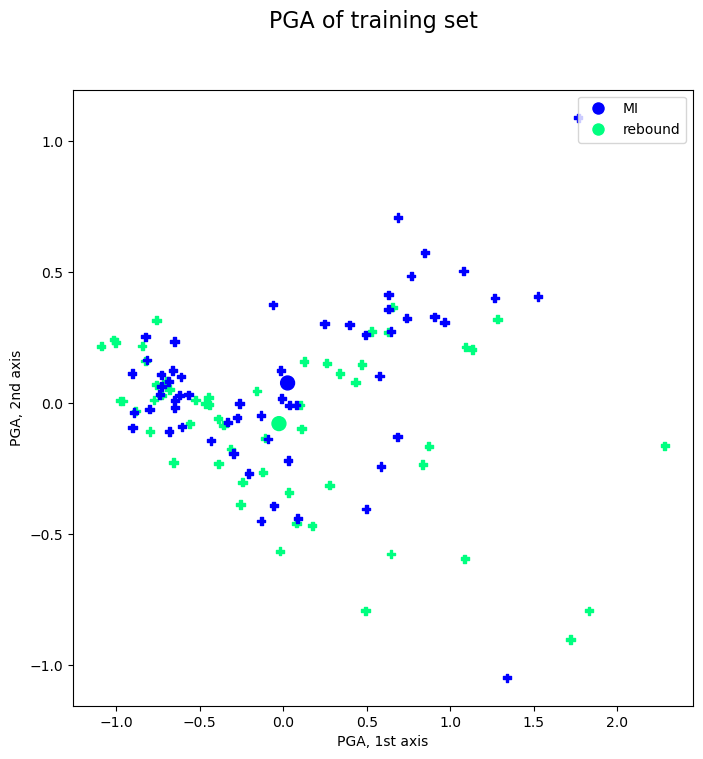

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle('PGA of training set', fontsize=16)
plot_pga(ax, ts_train, combined_labels, ts_means)
plt.show()

# Now only with MI trials

In [62]:
from pyriemann.estimation import BlockCovariances
cov_ext_trials = BlockCovariances(
    estimator='lwf', block_size=len(ch_names)
).transform(epochs_MI_stage2)

### Show examplefor each class

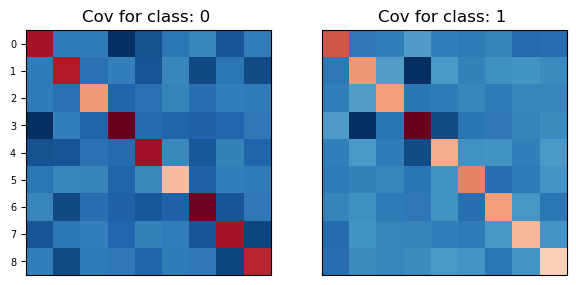

In [63]:
plt.figure(figsize=(7, 7))
event_id = list(set(labels_MI_stage2))
for i, l in enumerate(event_id):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(cov_ext_trials[labels_MI_stage2 == event_id[l]][10],
               cmap=plt.get_cmap('RdBu_r'))
    plt.title(f'Cov for class: {l} ')
    plt.xticks([])
    if i == 0 or i == 2:
        #plt.yticks(np.arange(len(ch_names_kernels)), ch_names_kernels)
        ax.tick_params(axis='both', which='major', labelsize=7)
    else:
        plt.yticks([])

## Classify with MDM

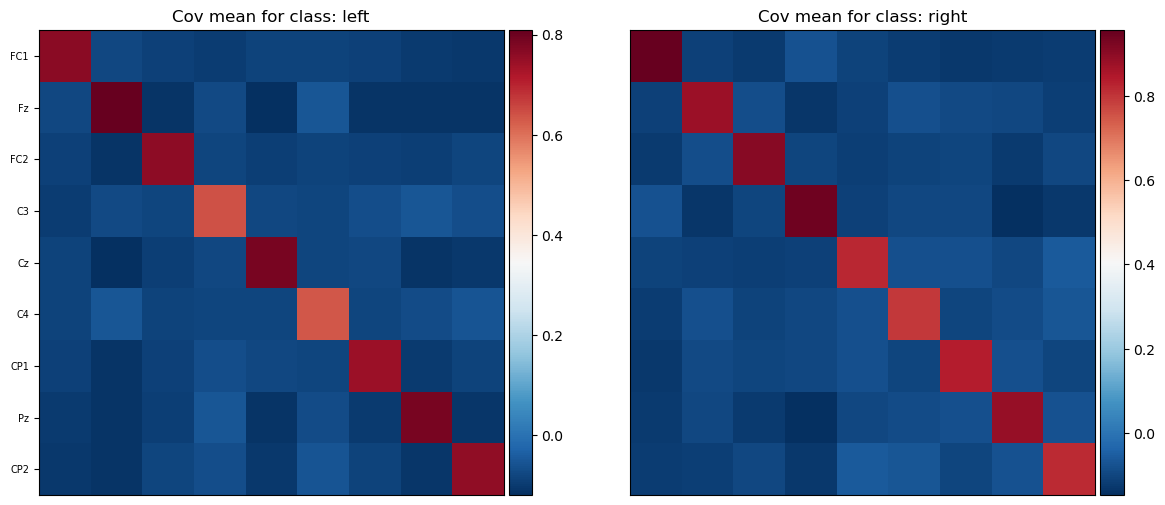

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

cov_centers = np.empty((len(event_id), len(ch_names)*len(kernels), len(ch_names)*len(kernels)))
for i, l in enumerate(event_id):
    cov_centers[i] = mean_riemann(cov_ext_trials[labels_MI_stage2 == event_id[l]])

plt.figure(figsize=(14, 14))
for i, l in enumerate(event_id):
    ax = plt.subplot(2, 2, i+1)
    im = ax.imshow(cov_centers[i], cmap=plt.get_cmap('RdBu_r'))
    if l == 0:
        ax.set_title(f'Cov mean for class: left')
    else:
        ax.set_title(f'Cov mean for class: right')
    # ax.set_title(f'Cov mean for class: {l} ')
    ax.set_xticks([])
    if i == 0 or i == 2:
        ax.set_yticks(np.arange(len(ch_names)), ch_names)
        ax.tick_params(axis='both', which='major', labelsize=7)
    else:
        ax.set_yticks([])

    # Create a new axes for the colorbar that is the same height as the original axes
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)

In [65]:
print("Number of trials: {}".format(len(cov_ext_trials)))

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=4, random_state=42)
mdm = MDM(metric=dict(mean='euclid', distance='euclid'))
scores = cross_val_score(mdm, cov_ext_trials, labels_MI_stage2, cv=cv, n_jobs=1)
print("MDM accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))

Number of trials: 57
MDM accuracy: 64.68% +/- 18.37


In [66]:
from sklearn.linear_model import LogisticRegressionCV

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=4, random_state=42)
mdm = MDM(metric=dict(mean='euclid', distance='euclid'))

TSLR = make_pipeline(
    TangentSpace(metric="euclid", tsupdate=False),
    LogisticRegressionCV(cv=5, n_jobs=-1)
)

scores = cross_val_score(TSLR, cov_ext_trials, labels_MI_stage2, cv=cv, n_jobs=1)
print("Tangent space accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))

Tangent space accuracy: 67.21% +/- 17.12


from lightgbm import LGBMClassifier as lgbm
from sklearn.model_selection import GridSearchCV

cv = RepeatedKFold(n_splits=7, n_repeats=4, random_state=42)

TSLR = make_pipeline(
    TangentSpace(metric="riemann", tsupdate=False),
    lgbm(n_jobs=1, verbose=0)
)

# Define the parameter grid
param_grid = {
    'lgbmclassifier__num_leaves': [31, 50, 100],
    'lgbmclassifier__max_depth': [-1, 50, 100],
    'lgbmclassifier__learning_rate': [0.1, 0.05, 0.01],
    'lgbmclassifier__n_estimators': [100, 200, 500]
}

# Perform grid search
grid_search = GridSearchCV(TSLR, param_grid, cv=cv, n_jobs=-1)
grid_search.fit(cov_ext_trials, labels_MI_stage2)

print("Best parameters: ", grid_search.best_params_)

# Evaluate the model with the best parameters
scores = cross_val_score(grid_search.best_estimator_, cov_ext_trials, labels_MI_stage2, cv=cv, n_jobs=1)
print("TS + GBM accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100, np.std(scores)*100))

In [67]:
mdm.fit(cov_ext_trials, labels_MI_stage2)

MDM(metric={'distance': 'euclid', 'mean': 'euclid'})

## Projection in tangent space to viz

In [68]:
pga = make_pipeline(
    TangentSpace(metric="riemann", tsupdate=False),
    PCA(n_components=2)
)

ts_train = pga.fit_transform(cov_ext_trials)
ts_means = pga.transform(np.array(mdm.covmeans_))

In [69]:
clabel = ['left', 'right']
cmap = plt.cm.winter

def plot_pga(ax, data, labels, centers):
    sc = ax.scatter(data[:, 0], data[:, 1], c=labels, marker='P', cmap=cmap)
    ax.scatter(
        centers[:, 0], centers[:, 1], c=np.array([0,1]), marker='o', s=100, cmap=cmap
        )
    ax.set(xlabel='PGA, 1st axis', ylabel='PGA, 2nd axis')
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/(len(clabel)-1)), markersize=10) for i in range(len(clabel))]
    ax.legend(handles, clabel, loc='upper right')
    return sc

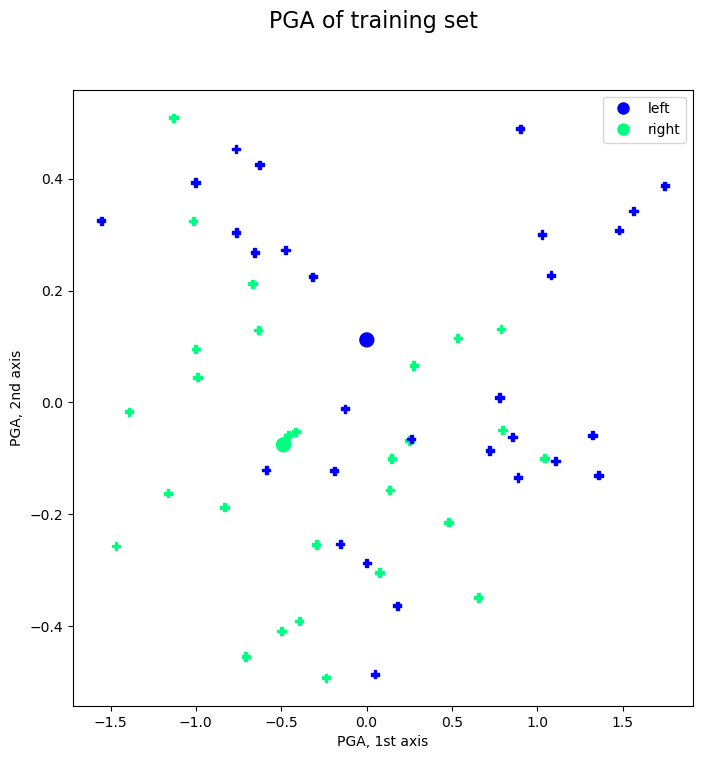

In [70]:
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle('PGA of training set', fontsize=16)
plot_pga(ax, ts_train, labels_MI_stage2, ts_means)
plt.show()